<a href="https://colab.research.google.com/github/Akif4362/lstm_research/blob/main/Prediction_of_Stock_Price_using_LSTM_(full_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing Libraries & Setting Up Device Agnostic Code

In [69]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

import requests
import zipfile
from pathlib import Path
from copy import deepcopy as dc

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 2. Downloading and Preparing Dataset

In [70]:
data_path = Path("data/")
csv_path = data_path / "stock_prices_data"

if csv_path.is_dir():
    print(f"{csv_path} directory exists.")
else:
    print(f"Did not find {csv_path} directory, creating one...")
    csv_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "timeseries_research_data.zip", "wb") as f:
        request = requests.get("https://github.com/Akif4362/lstm_research/raw/main/data/timeseries_research_data.zip")
        print("Downloading time series data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "timeseries_research_data.zip", "r") as zip_ref:
        print("Unzipping time series data...")
        zip_ref.extractall(csv_path)

data/stock_prices_data directory exists.


In [71]:
df = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/AAMRATECH_data.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,10/1/2012,42.296913,46.130274,40.607633,44.765866,2630100
1,10/2/2012,46.780017,47.949485,42.231904,42.556775,1728870
2,10/3/2012,43.531389,44.116124,39.633019,40.022899,1206150
3,10/4/2012,41.257376,41.257376,36.839194,37.164065,2014650
4,10/7/2012,37.683876,40.867496,37.099142,40.802573,1749330


In [72]:
df = df[["Date", "Close"]]
df.head()

,Date,Close
0,10/1/2012,44.765866
1,10/2/2012,42.556775
2,10/3/2012,40.022899
3,10/4/2012,37.164065
4,10/7/2012,40.802573


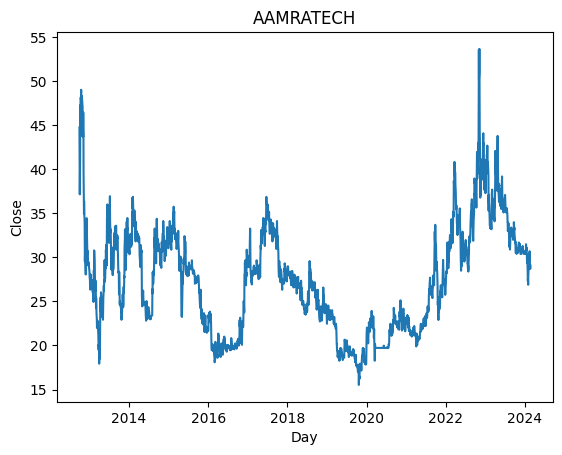

In [73]:
# Changing datatype of Date column in DateTime Format
df["Date"] = pd.to_datetime(df["Date"])

# Visualizing the time-series data
plt.plot(df["Date"], df["Close"])
plt.xlabel('Day')
plt.ylabel('Close')
plt.title(f"AAMRATECH")
plt.show();

In [74]:
# prepare dataframe for creating input vectors for LSTM
def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)

  df.set_index("Date", inplace=True)

  for i in range(1, n_steps+1):
    df[f"Close(t-{i})"] = df["Close"].shift(i)

  df.dropna(inplace=True)

  return df

TIMESTEP = 7
shifted_df = prepare_dataframe_for_lstm(df, TIMESTEP)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2012-10-10,44.505918,47.299743,43.336449,40.802573,37.164065,40.022899,42.556775,44.765866
2012-10-11,48.014408,44.505918,47.299743,43.336449,40.802573,37.164065,40.022899,42.556775
2012-10-14,48.209348,48.014408,44.505918,47.299743,43.336449,40.802573,37.164065,40.022899
2012-10-15,47.949485,48.209348,48.014408,44.505918,47.299743,43.336449,40.802573,37.164065
2012-10-17,49.040995,47.949485,48.209348,48.014408,44.505918,47.299743,43.336449,40.802573
...,...,...,...,...,...,...,...,...
2024-02-14,30.100000,30.700000,29.600000,29.900000,30.100000,30.400000,29.500000,29.700000
2024-02-15,29.500000,30.100000,30.700000,29.600000,29.900000,30.100000,30.400000,29.500000
2024-02-18,28.800000,29.500000,30.100000,30.700000,29.600000,29.900000,30.100000,30.400000


In [75]:
# Converting dataframe to numpy array
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[44.50591767, 47.29974271, 43.3364494 , ..., 40.0228988 ,
        42.5567753 , 44.76586621],
       [48.01440823, 44.50591767, 47.29974271, ..., 37.16406518,
        40.0228988 , 42.5567753 ],
       [48.2093482 , 48.01440823, 44.50591767, ..., 40.8025729 ,
        37.16406518, 40.0228988 ],
       ...,
       [28.8       , 29.5       , 30.1       , ..., 29.9       ,
        30.1       , 30.4       ],
       [28.7       , 28.8       , 29.5       , ..., 29.6       ,
        29.9       , 30.1       ],
       [29.1       , 28.7       , 28.8       , ..., 30.7       ,
        29.6       , 29.9       ]])

In [76]:
# Scaling our data to be between -1 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[ 0.51916835,  0.66561025,  0.45786918, ...,  0.28418521,
         0.41700157,  0.53279389],
       [ 0.70307035,  0.51916835,  0.66561025, ...,  0.13433581,
         0.28418521,  0.41700157],
       [ 0.71328838,  0.70307035,  0.51916835, ...,  0.32505282,
         0.13433581,  0.28418521],
       ...,
       [-0.30407732, -0.26738593, -0.23593617, ..., -0.24641942,
        -0.23593617, -0.22021128],
       [-0.30931895, -0.30407732, -0.26738593, ..., -0.2621443 ,
        -0.24641942, -0.23593617],
       [-0.28835244, -0.30931895, -0.30407732, ..., -0.2044864 ,
        -0.2621443 , -0.24641942]])

In [77]:
# Taking our input and output
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((2665, 7), (2665,))

In [78]:
# Flipping the X array to match proper sequence of input for LSTM
X = dc(np.flip(X, axis=1))
X

array([[ 0.53279389,  0.41700157,  0.28418521, ...,  0.32505282,
         0.45786918,  0.66561025],
       [ 0.41700157,  0.28418521,  0.13433581, ...,  0.45786918,
         0.66561025,  0.51916835],
       [ 0.28418521,  0.13433581,  0.32505282, ...,  0.66561025,
         0.51916835,  0.70307035],
       ...,
       [-0.22021128, -0.23593617, -0.24641942, ..., -0.2044864 ,
        -0.23593617, -0.26738593],
       [-0.23593617, -0.24641942, -0.2621443 , ..., -0.23593617,
        -0.26738593, -0.30407732],
       [-0.24641942, -0.2621443 , -0.2044864 , ..., -0.26738593,
        -0.30407732, -0.30931895]])

In [79]:
# Splitting data into train and test
split_index = int(len(X) * 0.90)

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2398, 7), (267, 7), (2398,), (267,))

In [80]:
# Fixing the dimensions as required for LSTM
X_train = X_train.reshape((-1, 7, 1))
X_test = X_test.reshape((-1, 7, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2398, 7, 1), (267, 7, 1), (2398, 1), (267, 1))

In [81]:
# Converting numpy array into PyTorch tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2398, 7, 1]),
 torch.Size([267, 7, 1]),
 torch.Size([2398, 1]),
 torch.Size([267, 1]))

# 3. Creating PyTorch Dataset and Dataloader

In [82]:
# Subclassing from the Dataset class to get out train and test datasets
from torch.utils.data import Dataset

class TimeSeriesData(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesData(X_train, y_train)
test_dataset = TimeSeriesData(X_test, y_test)

In [83]:
# Creating dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [84]:
for _, (X, y) in enumerate(train_dataloader):
  print(X.shape, y.shape)
  break

torch.Size([32, 7, 1]) torch.Size([32, 1])


# 4. Creating our LSTM Model

In [85]:
# Creating our LSTM model
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1, 5, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

# 5. Predicting Closing Price for AAMRATECH

In [86]:
# Setting up our loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [87]:
# Creating train step
def train_step(model, dataloader, loss_fn, optimizer, epoch, print_every=40, device=device):
  """trains model for one epoch"""
  model.train()
  train_loss = 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss / len(dataloader)

  if (epoch + 1) % print_every == 0:
    print(f"Epoch {epoch + 1}, train_loss: {train_loss:.5f}")

In [88]:
# Creating test step
def test_step(model, dataloader, loss_fn, epoch, print_every=40, device=device):
  """tests model for one epoch"""
  model.eval()
  test_loss = 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      y_logit = model(X)
      loss = loss_fn(y_logit, y)
      test_loss += loss.item()

  test_loss = test_loss / len(dataloader)

  if (epoch + 1) % print_every == 0:
    print(f"Epoch {epoch + 1}, test_loss: {test_loss:.5f}\n-------------------------------")

In [89]:
# Traing our model
epochs = 200

for epoch in range(epochs):
  train_step(model, train_dataloader, loss_fn, optimizer, epoch=epoch)
  test_step(model, test_dataloader, loss_fn, epoch=epoch)

Epoch 40, train_loss: 0.03508
Epoch 40, test_loss: 0.03490
-------------------------------
Epoch 80, train_loss: 0.02894
Epoch 80, test_loss: 0.02777
-------------------------------
Epoch 120, train_loss: 0.02763
Epoch 120, test_loss: 0.02579
-------------------------------
Epoch 160, train_loss: 0.02736
Epoch 160, test_loss: 0.02545
-------------------------------
Epoch 200, train_loss: 0.02721
Epoch 200, test_loss: 0.02546
-------------------------------


In [90]:
# Getting the unscaled values of the predictions on test set
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], TIMESTEP+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([41.03199558, 41.69506821, 41.82685706, 42.16005389, 40.92423678,
       40.19725915, 40.32785514, 40.43525233, 40.18766169, 39.19021132,
       36.03989197, 35.21515697, 36.92804968, 36.15062098, 35.91212149,
       35.50605858, 35.50866447, 35.10730737, 34.62383535, 33.5282978 ,
       34.26138269, 33.80026887, 33.24072929, 33.55645566, 33.8258079 ,
       33.92718379, 34.13337266, 33.82681455, 33.13829258, 33.86503781,
       35.20352104, 36.64747913, 37.14594789, 37.54954107, 36.88454753,
       36.30150966, 36.57623019, 35.39806922, 35.42389836, 36.08113234,
       34.89986324, 35.1406341 , 34.20876871, 34.34721192, 34.61638492,
       34.51536658, 34.32938601, 34.03239757, 34.13791763, 35.70819659,
       35.57512519, 38.91325943, 41.48623528, 40.5850876 , 40.8322973 ,
       39.32452064, 39.41389075, 38.2262881 , 37.44733066, 38.6365327 ,
       38.39078337, 39.0444365 , 40.39313437, 40.2095215 , 42.92334665,
       42.38961631, 41.5458942 , 40.50496812, 37.4256363 , 38.15

In [91]:
# Getting the unscaled values of the outputs of the test set
dummies = np.zeros((X_test.shape[0], TIMESTEP+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([42.19999991, 42.30000001, 42.69999983, 41.20000007, 40.49999995,
       40.70000015, 40.80000025, 40.49999995, 39.40000001, 36.10000005,
       35.29999998, 37.10000004, 36.29999997, 35.99999996, 35.59999999,
       35.59999999, 35.20000003, 34.7       , 33.60000002, 34.3       ,
       33.90000003, 33.30000001, 33.60000002, 33.90000003, 33.99999999,
       34.20000001, 33.90000003, 33.20000006, 33.90000003, 35.29999998,
       36.80000003, 37.29999995, 37.70000006, 36.99999994, 36.40000006,
       36.69999993, 35.50000004, 35.50000004, 36.20000001, 35.00000001,
       35.20000003, 34.3       , 34.40000001, 34.7       , 34.6       ,
       34.40000001, 34.10000002, 34.20000001, 35.80000004, 35.70000002,
       39.2000001 , 42.09999981, 40.80000025, 41.20000007, 39.50000011,
       39.69999974, 38.39999989, 37.59999996, 38.90000009, 38.60000008,
       39.29999992, 40.80000025, 40.49999995, 43.79999977, 42.79999993,
       41.90000019, 40.80000025, 37.49999986, 38.39999989, 37.40

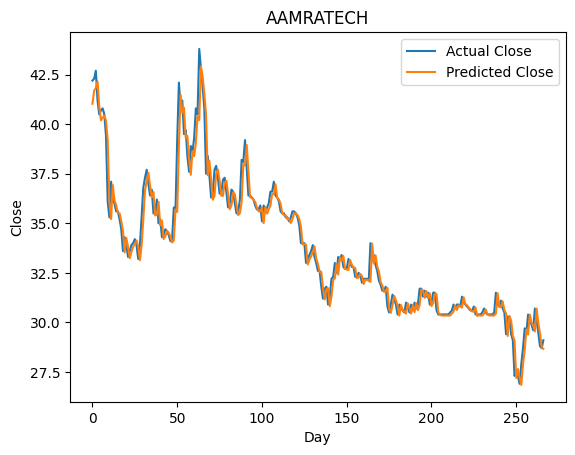

In [92]:
# Plotting the Results of test set
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title("AAMRATECH")
plt.show()

# 6. Functionizing the training process

In [93]:
def lstm_time_series(df, company_name=None):
  print(f"FOR {company_name}")
  print("--------------------------")
  print("--------------------------")
  df = df[["Date", "Close"]]
  df["Date"] = pd.to_datetime(df["Date"])

  plt.plot(df["Date"], df["Close"])
  plt.xlabel('Day')
  plt.ylabel('Close')
  plt.title(f"{company_name}")
  plt.show()

  shifted_df = prepare_dataframe_for_lstm(df, 7)
  shifted_df_as_np = shifted_df.to_numpy()

  scaler = MinMaxScaler(feature_range=(-1, 1))
  shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

  X = shifted_df_as_np[:, 1:]
  y = shifted_df_as_np[:, 0]

  X = dc(np.flip(X, axis=1))

  split_index = int(len(X) * 0.90)
  X_train = X[:split_index]
  X_test = X[split_index:]

  y_train = y[:split_index]
  y_test = y[split_index:]

  X_train = X_train.reshape((-1, 7, 1))
  X_test = X_test.reshape((-1, 7, 1))

  y_train = y_train.reshape((-1, 1))
  y_test = y_test.reshape((-1, 1))

  X_train = torch.tensor(X_train).float()
  X_test = torch.tensor(X_test).float()
  y_train = torch.tensor(y_train).float()
  y_test = torch.tensor(y_test).float()

  train_dataset = TimeSeriesData(X_train, y_train)
  test_dataset = TimeSeriesData(X_test, y_test)

  batch_size = 32

  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
  test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

  epochs = 200

  for epoch in range(epochs):
    train_step(model, train_dataloader, loss_fn, optimizer, epoch=epoch)
    test_step(model, test_dataloader, loss_fn, epoch=epoch)

  test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

  dummies = np.zeros((X_test.shape[0], 7+1))
  dummies[:, 0] = test_predictions
  dummies = scaler.inverse_transform(dummies)

  test_predictions = dc(dummies[:, 0])
  test_predictions

  dummies = np.zeros((X_test.shape[0], 7+1))
  dummies[:, 0] = y_test.flatten()
  dummies = scaler.inverse_transform(dummies)

  new_y_test = dc(dummies[:, 0])
  new_y_test

  plt.plot(new_y_test, label='Actual Close')
  plt.plot(test_predictions, label='Predicted Close')
  plt.xlabel('Day')
  plt.ylabel('Close')
  if company_name:
    plt.title(f"{company_name}")
  plt.legend()
  plt.show()

# 7. ADVENT

FOR ADVENT
--------------------------
--------------------------


<ipython-input-93-5867f7a4be12>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


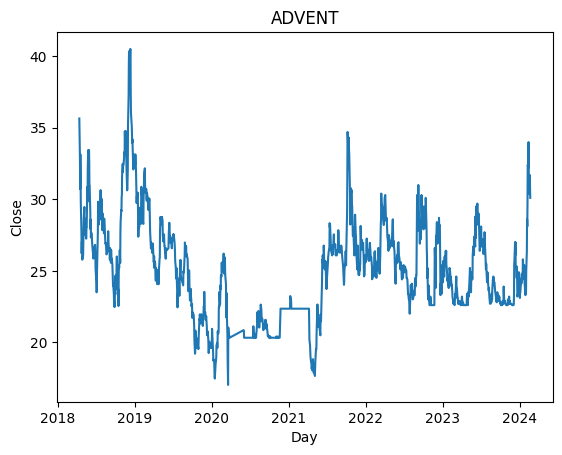

Epoch 40, train_loss: 0.04330
Epoch 40, test_loss: 0.04480
-------------------------------
Epoch 80, train_loss: 0.04304
Epoch 80, test_loss: 0.04463
-------------------------------
Epoch 120, train_loss: 0.04305
Epoch 120, test_loss: 0.04464
-------------------------------
Epoch 160, train_loss: 0.04300
Epoch 160, test_loss: 0.04499
-------------------------------
Epoch 200, train_loss: 0.04301
Epoch 200, test_loss: 0.04471
-------------------------------


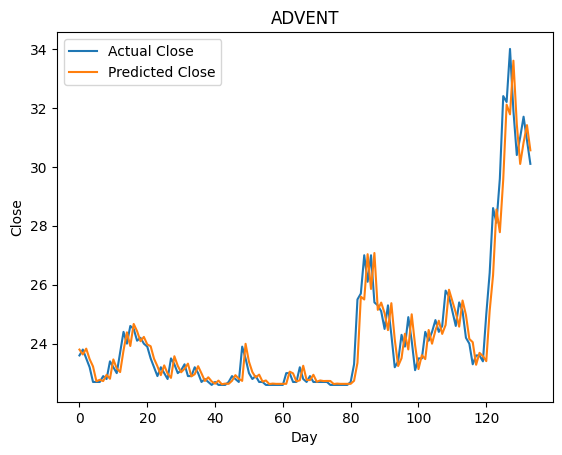

In [94]:
df_advent = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/ADVENT_data.csv")
lstm_time_series(df_advent, "ADVENT")

# 8. AGRODENIM

FOR AGRODENIM
--------------------------
--------------------------


<ipython-input-93-5867f7a4be12>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


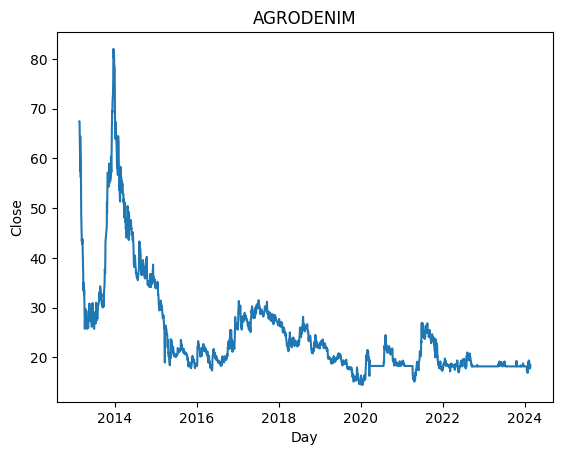

Epoch 40, train_loss: 0.01435
Epoch 40, test_loss: 0.00363
-------------------------------
Epoch 80, train_loss: 0.01405
Epoch 80, test_loss: 0.00317
-------------------------------
Epoch 120, train_loss: 0.01563
Epoch 120, test_loss: 0.00395
-------------------------------
Epoch 160, train_loss: 0.01492
Epoch 160, test_loss: 0.00379
-------------------------------
Epoch 200, train_loss: 0.01498
Epoch 200, test_loss: 0.00455
-------------------------------


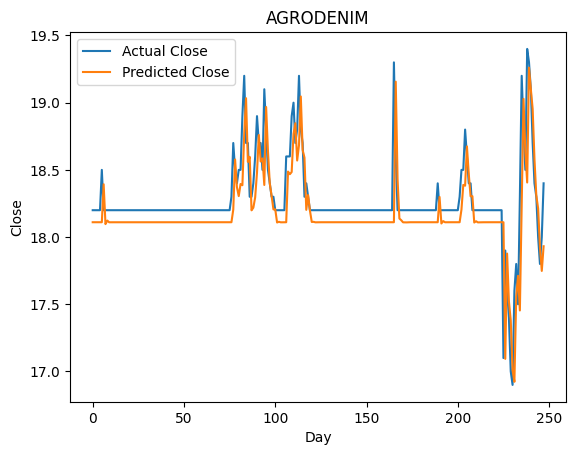

In [95]:
df_agrodenim = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/ARGONDENIM_data.csv")
lstm_time_series(df_agrodenim, "AGRODENIM")

# 9. BDTHAIFOOD

FOR BDTHAIFOOD
--------------------------
--------------------------


<ipython-input-93-5867f7a4be12>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


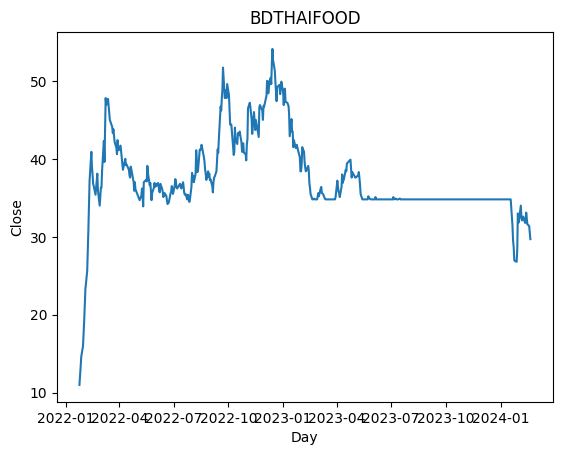

Epoch 40, train_loss: 0.04308
Epoch 40, test_loss: 0.04065
-------------------------------
Epoch 80, train_loss: 0.04287
Epoch 80, test_loss: 0.04134
-------------------------------
Epoch 120, train_loss: 0.04200
Epoch 120, test_loss: 0.04354
-------------------------------
Epoch 160, train_loss: 0.04195
Epoch 160, test_loss: 0.04383
-------------------------------
Epoch 200, train_loss: 0.04187
Epoch 200, test_loss: 0.04406
-------------------------------


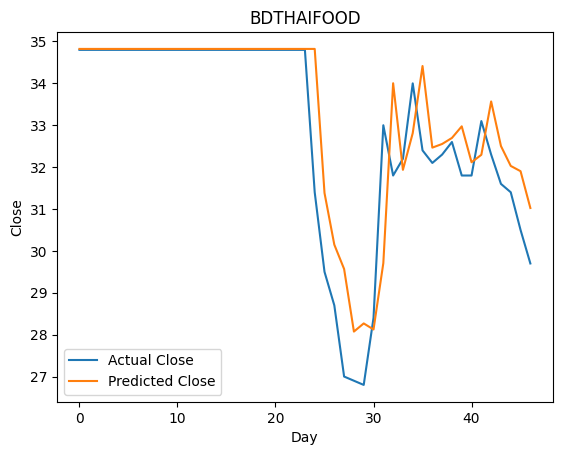

In [96]:
df_bdthaifood = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/BDTHAIFOOD_data.csv")
lstm_time_series(df_bdthaifood, "BDTHAIFOOD")

# 10. ECABLES

FOR ECABLES
--------------------------
--------------------------


<ipython-input-93-5867f7a4be12>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


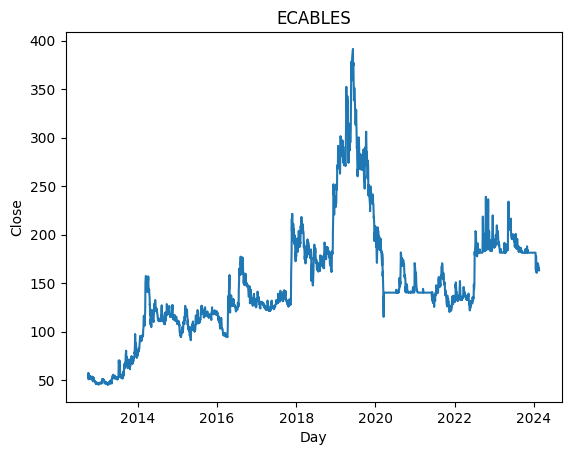

Epoch 40, train_loss: 0.01806
Epoch 40, test_loss: 0.01235
-------------------------------
Epoch 80, train_loss: 0.01828
Epoch 80, test_loss: 0.01204
-------------------------------
Epoch 120, train_loss: 0.01812
Epoch 120, test_loss: 0.01185
-------------------------------
Epoch 160, train_loss: 0.01828
Epoch 160, test_loss: 0.01271
-------------------------------
Epoch 200, train_loss: 0.01817
Epoch 200, test_loss: 0.01222
-------------------------------


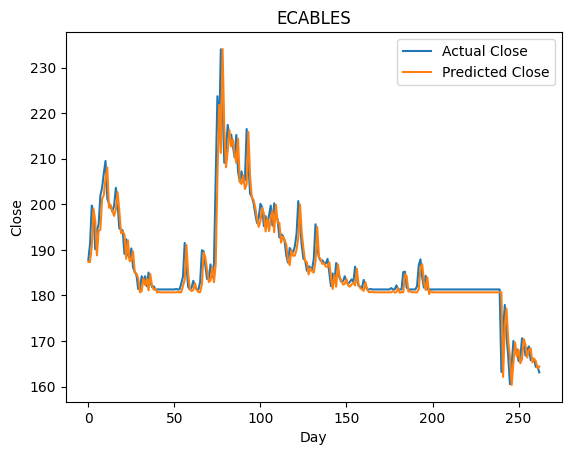

In [97]:
df_ecables = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/ECABLES_data.csv")
lstm_time_series(df_ecables, "ECABLES")

# 11. KEYACOSMET

FOR KEYACOSMET
--------------------------
--------------------------


<ipython-input-93-5867f7a4be12>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


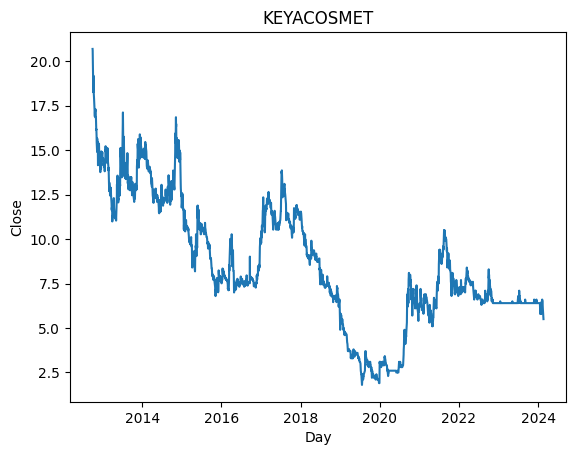

Epoch 40, train_loss: 0.02136
Epoch 40, test_loss: 0.01143
-------------------------------
Epoch 80, train_loss: 0.02088
Epoch 80, test_loss: 0.00967
-------------------------------
Epoch 120, train_loss: 0.02086
Epoch 120, test_loss: 0.00905
-------------------------------
Epoch 160, train_loss: 0.02066
Epoch 160, test_loss: 0.00854
-------------------------------
Epoch 200, train_loss: 0.02029
Epoch 200, test_loss: 0.00655
-------------------------------


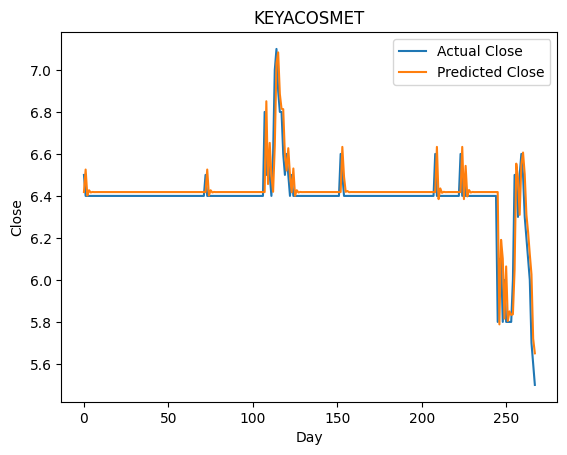

In [98]:
df_keyacosmet = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/KEYACOSMET_data.csv")
lstm_time_series(df_keyacosmet, "KEYACOSMET")

# 12. MEGHNAPET

FOR MEGHNAPET
--------------------------
--------------------------


<ipython-input-93-5867f7a4be12>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


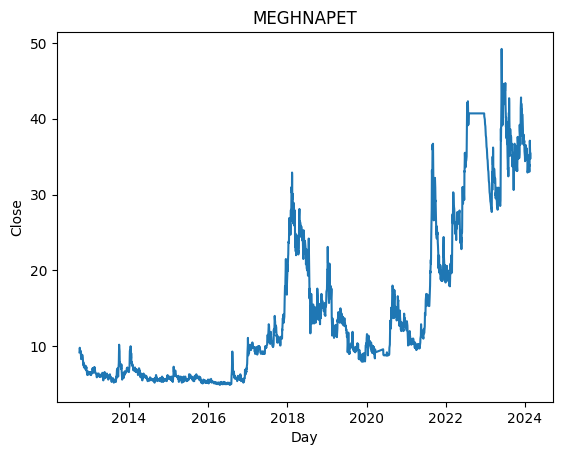

Epoch 40, train_loss: 0.01924
Epoch 40, test_loss: 0.04394
-------------------------------
Epoch 80, train_loss: 0.01990
Epoch 80, test_loss: 0.04441
-------------------------------
Epoch 120, train_loss: 0.01879
Epoch 120, test_loss: 0.04397
-------------------------------
Epoch 160, train_loss: 0.01897
Epoch 160, test_loss: 0.04408
-------------------------------
Epoch 200, train_loss: 0.01897
Epoch 200, test_loss: 0.04403
-------------------------------


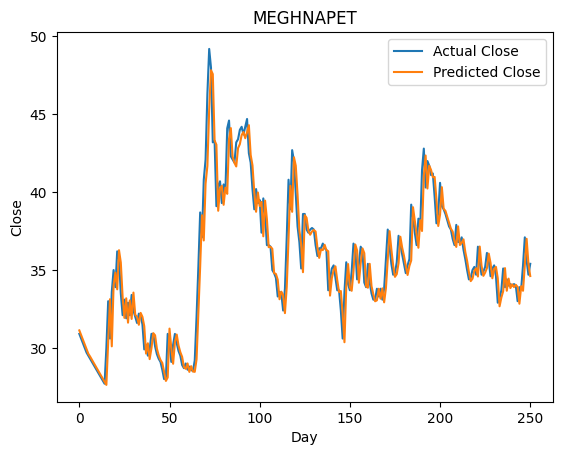

In [99]:
df_meghnapet = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/MEGHNAPET_data.csv")
lstm_time_series(df_meghnapet, "MEGHNAPET")

# 13. PRIMETEX

FOR PRIMETEX
--------------------------
--------------------------


<ipython-input-93-5867f7a4be12>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


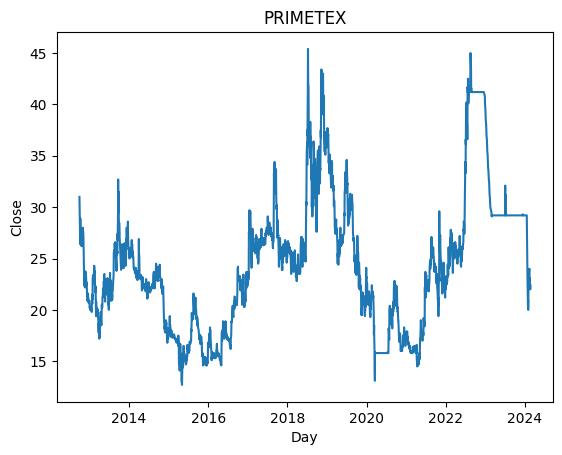

Epoch 40, train_loss: 0.02971
Epoch 40, test_loss: 0.01778
-------------------------------
Epoch 80, train_loss: 0.03117
Epoch 80, test_loss: 0.02411
-------------------------------
Epoch 120, train_loss: 0.02965
Epoch 120, test_loss: 0.01478
-------------------------------
Epoch 160, train_loss: 0.02957
Epoch 160, test_loss: 0.01853
-------------------------------
Epoch 200, train_loss: 0.02952
Epoch 200, test_loss: 0.01800
-------------------------------


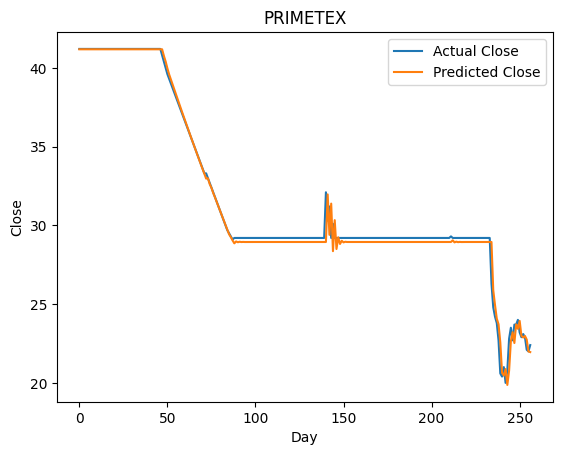

In [100]:
df_primetex = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/PRIMETEX_data.csv")
lstm_time_series(df_primetex, "PRIMETEX")

# 14. PUBALIBANK

FOR PUBALIBANK
--------------------------
--------------------------


<ipython-input-93-5867f7a4be12>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


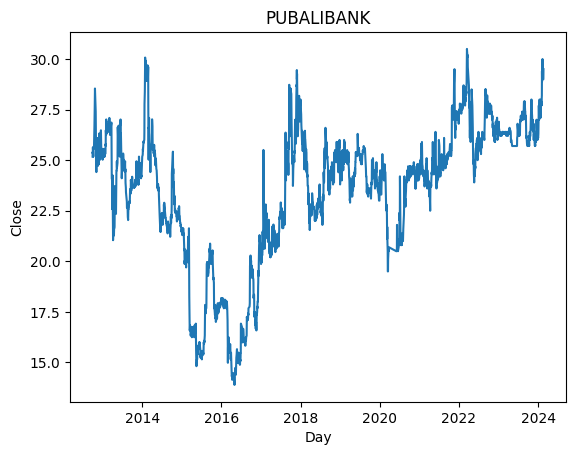

Epoch 40, train_loss: 0.03199
Epoch 40, test_loss: 0.02017
-------------------------------
Epoch 80, train_loss: 0.03180
Epoch 80, test_loss: 0.02027
-------------------------------
Epoch 120, train_loss: 0.03172
Epoch 120, test_loss: 0.02031
-------------------------------
Epoch 160, train_loss: 0.03170
Epoch 160, test_loss: 0.02039
-------------------------------
Epoch 200, train_loss: 0.03164
Epoch 200, test_loss: 0.02066
-------------------------------


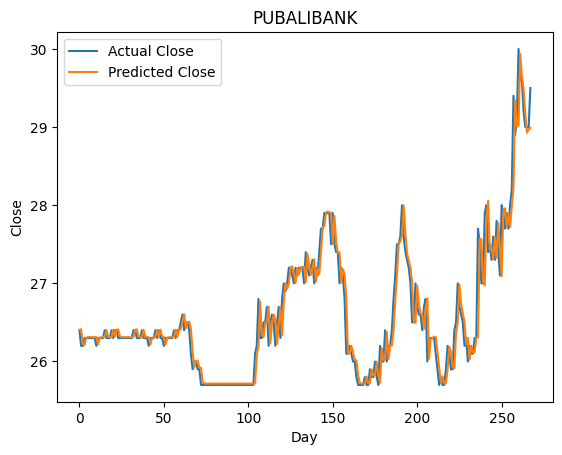

In [101]:
df_pubalibank = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/PUBALIBANK_data.csv")
lstm_time_series(df_pubalibank, "PUBALIBANK")

# 15. UNIONCAP

FOR UNIONCAP
--------------------------
--------------------------


<ipython-input-93-5867f7a4be12>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


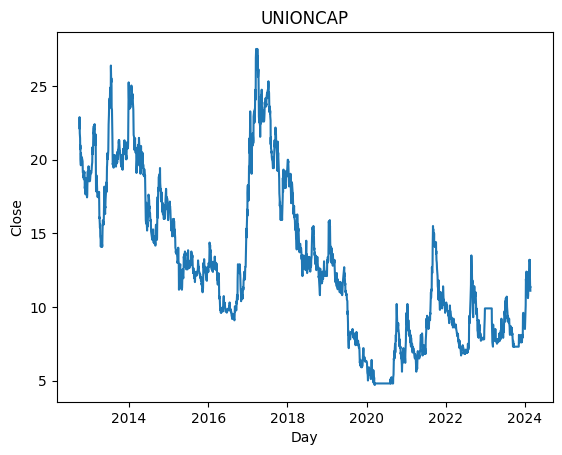

Epoch 40, train_loss: 0.02348
Epoch 40, test_loss: 0.01958
-------------------------------
Epoch 80, train_loss: 0.02326
Epoch 80, test_loss: 0.01970
-------------------------------
Epoch 120, train_loss: 0.02348
Epoch 120, test_loss: 0.01963
-------------------------------
Epoch 160, train_loss: 0.02311
Epoch 160, test_loss: 0.02019
-------------------------------
Epoch 200, train_loss: 0.02313
Epoch 200, test_loss: 0.01962
-------------------------------


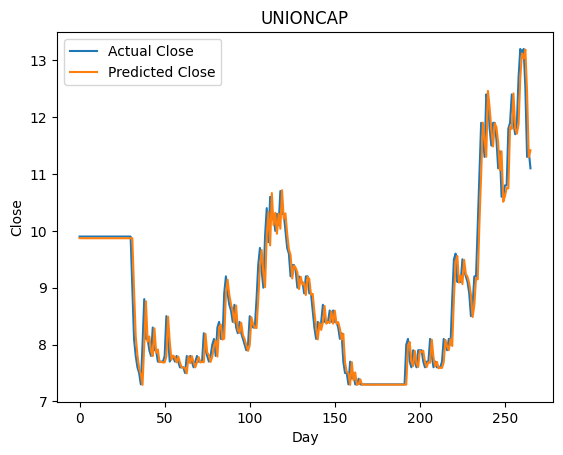

In [102]:
df_unioncap = pd.read_csv("/content/data/stock_prices_data/timeseries_research_data/UNIONCAP_data.csv")
lstm_time_series(df_unioncap, "UNIONCAP")